<a href="https://colab.research.google.com/github/fjadidi2001/Image_Inpaint/blob/main/for1Pic_Jan2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving Mona_Lisa.jpg to Mona_Lisa (1).jpg


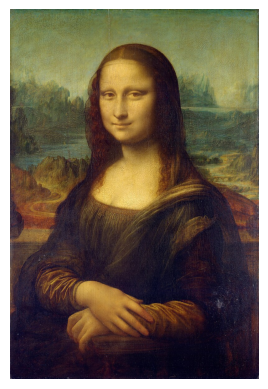

In [5]:
from google.colab import files
from PIL import Image
import matplotlib.pyplot as plt

# Upload the file
uploaded = files.upload()

# Open the image using PIL
image = Image.open('Mona_Lisa.jpg')

# Display the image
plt.imshow(image)
plt.axis('off')  # Hide the axis
plt.show()